In [1]:
from evo.core import metrics
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

[DEBUG][2021-01-01 20:24:25,403][log.configure_logging():115]
System info:
Python 3.7.4
Linux-4.15.0-128-generic-x86_64-with-debian-stretch-sid
hpl@titan-ubuntu



In [95]:
from mathutils import Matrix, Vector
def get_tq_from_matrix(RT):
    t = RT.decompose()[0]
    q = RT.decompose()[1]
    tq = [t[0], t[1], t[2], q.x, q.y, q.z, q.w]
    return tq
def get_RcC_from_RT(RT):
    R_cv2bcam = Matrix(
        ((1, 0,  0),
        (0, -1, 0),
        (0, 0, -1)))
    R = Matrix((RT[0][0:3],
                RT[1][0:3],
                RT[2][0:3])) # direction of world axes in cam frame
    t = Vector((RT[0][3],
                RT[1][3],
                RT[2][3])) # pos of world origin in cam frame
    # Note: axes position direction correction from cv space to world space
    R = R_cv2bcam @ R
    t = R_cv2bcam @ t
    Rc = R.transposed()    # camera rotation in world coord
    C = -1 * Rc @ t        # pos of cam center in world coord

    RcC = Matrix((
                Rc[0][:] + (C[0],),
                Rc[1][:] + (C[1],),
                Rc[2][:] + (C[2],),
                (0, 0, 0, 1)))
    return RcC
def get_reconstructed_traj_file(source, dest):
    file = open(source, "r")
    num = int(file.readline()[0:-1])
    cam_extmat_tq_rec = []
    for fr_num in range(num):
        ext_mat = np.identity(4)
        row1 = file.readline()[0:-1].split(' ')

        ext_mat[0,:] = [float(_) for _ in row1[1:]]
        ext_mat[1,:] = [float(_) for _ in file.readline()[0:-1].split(' ')]
        ext_mat[2,:] = [float(_) for _ in file.readline()[0:-1].split(' ')]
        ext_mat = Matrix(ext_mat)
        tq = get_tq_from_matrix(get_RcC_from_RT(ext_mat))
        tq[0] = -tq[0]
        tq.insert(0, int(row1[0]))
        cam_extmat_tq_rec.append(tq)

    cam_extmat_tq_rec = np.matrix(cam_extmat_tq_rec)
    np.savetxt(dest, cam_extmat_tq_rec, fmt='%.5f')

exp_dir = "/home/hpl/Documents/cysto3D/EndoVidSynthesis/data/Ms-Tsis_t10_s3"
get_reconstructed_traj_file(
    source=exp_dir+'/base_experiment/sfm/results/model-3-cams.txt', 
    dest=exp_dir+'/base_experiment/sfm/results/model-3-cams_wmat_tq.txt')
   

In [96]:
from evo.tools import file_interface

ref_file = exp_dir + "/base_data/cam_wmat_tq_gt.txt"
est_file = exp_dir + '/base_experiment/sfm/results/model-3-cams_wmat_tq.txt'

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est = file_interface.read_tum_trajectory_file(est_file)

[DEBUG][2021-01-02 20:27:08,465][file_interface.read_tum_trajectory_file():113]
Loaded 600 stamps and poses from: /home/hpl/Documents/cysto3D/EndoVidSynthesis/data/Ms-Tsis_t10_s3/base_data/cam_wmat_tq_gt.txt
[DEBUG][2021-01-02 20:27:08,468][file_interface.read_tum_trajectory_file():113]
Loaded 57 stamps and poses from: /home/hpl/Documents/cysto3D/EndoVidSynthesis/data/Ms-Tsis_t10_s3/base_experiment/sfm/results/model-3-cams_wmat_tq.txt


In [97]:
from evo.core import sync

max_diff = 0.1

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)

[DEBUG][2021-01-02 20:27:13,566][sync.associate_trajectories():114]
Found 57 of max. 57 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.1 (s) and time offset: 0.0 (s).


In [98]:
import copy

traj_est_aligned = copy.deepcopy(traj_est)
traj_est_aligned.align(traj_ref, correct_scale=True, correct_only_scale=False)

[DEBUG][2021-01-02 20:27:16,533][trajectory.align():199]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2021-01-02 20:27:16,538][trajectory.align():211]
Rotation of alignment:
[[-0.96195698 -0.27316191 -0.00461958]
 [-0.26251608  0.91952006  0.29252036]
 [-0.07565762  0.28260472 -0.95624814]]
Translation of alignment:
[0.00119148 0.00099435 0.02267263]
[DEBUG][2021-01-02 20:27:16,540][trajectory.align():212]
Scale correction: 0.00048261777776699774


(array([[-0.96195698, -0.27316191, -0.00461958],
        [-0.26251608,  0.91952006,  0.29252036],
        [-0.07565762,  0.28260472, -0.95624814]]),
 array([0.00119148, 0.00099435, 0.02267263]),
 0.00048261777776699774)

<IPython.core.display.Javascript object>


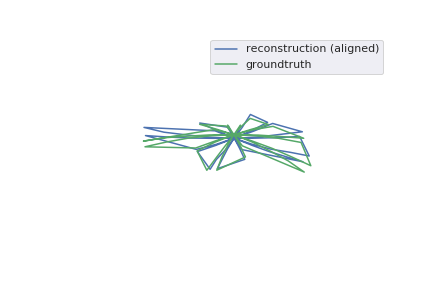

In [99]:
fig = plt.figure()
traj_by_label = {
#     "estimate (not aligned)": traj_est,
    "reconstruction (aligned)": traj_est_aligned,
    "groundtruth": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
ax = plt.gca(); ax.set_facecolor((1,1,1))
plt.axis('off')
plt.show()

In [94]:
""" APE """
pose_relation = metrics.PoseRelation.full_transformation
pose_relation = metrics.PoseRelation.translation_part
pose_relation = metrics.PoseRelation.rotation_part
use_aligned_trajectories = True
if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)
    
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)
ape_mean, ape_std = ape_metric.get_statistic(metrics.StatisticsType.mean), ape_metric.get_statistic(metrics.StatisticsType.std)
print('APEmean=',ape_mean,',APEstd=', ape_std)
# ape_stats = ape_metric.get_all_statistics()
# pprint.pprint(ape_stats)

# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
# fig = plt.figure()
# plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
#                  statistics={s:v for s,v in ape_stats.items() if s == "APE" or s == "median"},
#                  name="APE$_i$", title="APE$_i$ of " + ape_metric.pose_relation.value, xlabel="frame index $i$")
# ax.legend()
# ax = plt.gca(); ax.set_facecolor((1,1,1))
# plt.show()

# plot_mode = plot.PlotMode.xyz
# fig = plt.figure()
# ax = plot.prepare_axis(fig, plot_mode)
# plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
# plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
#                    plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
# ax.legend()
# ax = plt.gca(); ax.set_facecolor((1,1,1))
# plt.axis('off')
# plt.show()

"""RPE"""
# normal mode
delta = 1
delta_unit = metrics.Unit.frames

# all pairs mode
all_pairs = False 
data = (traj_ref, traj_est_aligned)

rpe_metric = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
rpe_metric.process_data(data)

rpe_mean, rpe_std = rpe_metric.get_statistic(metrics.StatisticsType.mean), rpe_metric.get_statistic(metrics.StatisticsType.std)
print('RPEmean=',rpe_mean,',RPEstd=', rpe_std)
# rpe_stats = rpe_metric.get_all_statistics()
# pprint.pprint(rpe_stats)

# # important: restrict data to delta ids for plot
# import copy
# traj_ref_plot = copy.deepcopy(traj_ref)
# traj_est_plot = copy.deepcopy(traj_est)
# traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
# traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

# fig = plt.figure()
# plot.error_array(fig.gca(), rpe_metric.error, x_array=seconds_from_start,
#                  statistics={s:v for s,v in rpe_stats.items() if s == "RPE" or s == "median"},
#                  name="RPE$_i$", title="RPE$_i$ of " + rpe_metric.pose_relation.value, xlabel="frame index $i$")
# ax.legend()
# ax = plt.gca(); ax.set_facecolor((1,1,1))
# plt.show()

# plot_mode = plot.PlotMode.xyz
# fig = plt.figure()
# ax = plot.prepare_axis(fig, plot_mode)
# plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
# plot.traj_colormap(ax, traj_est_plot, rpe_metric.error, plot_mode, min_map=rpe_stats["min"], max_map=rpe_stats["max"])
# ax.legend()
# ax = plt.gca(); ax.set_facecolor((1,1,1))
# plt.axis('off')
# plt.show()

[DEBUG][2021-01-01 21:00:49,071][metrics.process_data():353]
Compared 280 absolute pose pairs.
[DEBUG][2021-01-01 21:00:49,073][metrics.process_data():355]
Calculating APE for rotation part pose relation...
APEmean= 2.8284259363138915 ,APEstd= 1.7721841457407493e-06
[DEBUG][2021-01-01 21:00:49,087][metrics.id_pairs_from_delta():414]
Found 279 pairs with delta 1 (frames) among 280 poses using consecutive pairs.
[DEBUG][2021-01-01 21:00:49,105][metrics.process_data():265]
Compared 279 relative pose pairs, delta = 1 (frames) with consecutive pairs.
[DEBUG][2021-01-01 21:00:49,106][metrics.process_data():268]
Calculating RPE for rotation part pose relation...
RPEmean= 0.0035488584586451616 ,RPEstd= 0.0019267771217694502
